In [83]:
#####Probit based Hierarchical Matrix Factorization####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.linalg
import scipy.stats as ss
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [84]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [85]:
##任意の相関行列(分散共分散行列)を作成する関数####
#任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper):
    #相関行列の初期値を定義する
    cov_vec = (upper - lower) *rand(col*col) + lower   #相関係数の乱数ベクトルを作成
    rho = np.reshape(np.array(cov_vec), (col, col)) * np.tri(col)   #乱数ベクトルを下三角行列化
    Sigma = np.diag(np.diag(rho + rho.T) + 1) - (rho + rho.T)   #対角成分を1にする
    
    #相関行列を正定値行列に変換
    eigen = scipy.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(eigen_val.shape[0]-1):
        if eigen_val[i] < 0:
            eigen_val[i] = (eigen_upper - eigen_lower) * rand(1) + eigen_lower
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(pow(np.diag(Sigma), 0.5)[:, np.newaxis], pow(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

#相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

In [87]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 10000   #ユーザー数
item = 3000   #アイテム数
pt = np.random.poisson(np.random.gamma(27.5, 1/0.25, hh), hh)   #購買接触数
hhpt = np.sum(pt)   #総サンプル数

In [88]:
##IDとインデックスを設定
#IDの設定
user_id = np.repeat(range(hh), pt)
pt_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    pt_id[user_id==i] = range(pt[i])
    
#インデックスの設定
user_index = [i for i in range(hh)]
for i in range(hh):
    user_index[i] = np.array(np.where(user_id==i)[0], dtype="int")

In [89]:
##説明変数の生成
##素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 5
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
X = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
column = X.shape[1]

In [90]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 4; k2 = 3; k3 = 4
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
column_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 3; k2 = 3; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
column_v = v.shape[1]

In [91]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi_topic = np.random.dirichlet(np.repeat(0.25, item), topic)
theta_topic = np.random.dirichlet(np.repeat(0.3, topic), hh)
z = np.array(rmnom(theta_topic[user_id, ], hhpt, topic, np.arange(hhpt), 0), dtype="int")

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_index[i]] = rmnom(phi_topic[z[user_index[i]], ], pt[i], item, np.arange(pt[i]), 0)
    
#アイテムインデックスを作成
index = np.array(range(hhpt))
item_index = [j for j in range(item)]
for j in range(item):
    item_index[j] = index[item_id==j]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [92]:
####応答変数の生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##階層モデルのパラメータの設定
    #階層モデルの分散を設定
    Cov = np.diag(np.random.uniform(0.01, 0.2, column))
    Cov_u = np.diag(np.random.uniform(0.01, 0.2, k))
    Cov_v = np.diag(np.random.uniform(0.01, 0.2, k))
    Covt = Cov.copy(); Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()
    
    #階層モデルの回帰係数を設定
    alpha = np.hstack((np.random.normal(-0.2, 0.4, column_u).reshape(column_u, 1), 
                       np.random.normal(0, 0.4, (column-1)*column_u).reshape(column_u, column-1)))
    alpha_u = np.random.normal(0, 0.4, k*column_u).reshape(column_u, k)
    alpha_v = np.random.normal(0, 0.4, k*column_v).reshape(column_v, k)
    alphat = alpha; alphat_u = alpha_u; alphat_v = alpha_v

    ##モデルパラメータを生成
    #素性ベクトルと行列分解のパラメータを生成
    beta = np.dot(u, alpha) + np.random.multivariate_normal(np.repeat(0, column), Cov, hh)
    theta_u = np.dot(u, alpha_u) + np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
    theta_v = np.dot(v, alpha_v) + np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)
    betat = beta.copy(); thetat_u = theta_u.copy(); thetat_v = theta_v.copy()         
                                                        
    #標準偏差を設定
    Sigma = 1

    ##潜在効用から応答変数を生成
    #回帰モデルの平均構造
    W = theta_u[user_id, :]; H = theta_v[item_id, :]
    beta_mu = np.dot(X * beta[user_id, :], np.repeat(1, column))
    WH = np.dot(W * H, np.repeat(1, k))
    mu = beta_mu + WH
    Prob = norm.cdf(mu, 0, Sigma)
    Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)

    #正規分布から潜在効用を生成
    U = np.random.normal(mu, Sigma, hhpt); UT = U.copy()   #潜在効用
    y = np.array((U > 0), dtype='int')   #潜在効用を購買ベクトルに変換
    
    #break条件
    if((np.mean(y) > 0.2) & (np.mean(y) < 0.4)):
        break

1


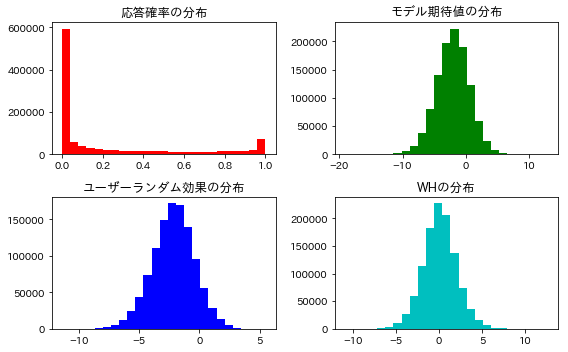

In [93]:
#潜在変数ごとのヒストグラム
dt = [Prob, mu, beta_mu, WH]
fig_range = np.append(np.array([0, np.min(mu), np.min(beta_mu), np.min(WH)]), 
                      np.array([1.0, np.max(mu), np.max(beta_mu), np.max(WH)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーランダム効果の分布", "WHの分布"]
fig = plt.figure(figsize=(8.0, 5.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [94]:
##テストデータの作成
##データの設定
#要素数を設定
pt0 = np.random.poisson(np.random.gamma(20.0, 1/0.25, hh))
N0 = np.sum(pt0)

#idとインデックスを作成
user_id0 = np.repeat(np.arange(hh), pt0)
user_index0 = [i for i in range(hh)]
for i in range(hh):
    user_index0[i] = np.array(np.where(user_id0==i)[0], dtype="int")

In [95]:
##素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 5
x1 = np.array(np.random.random(N0*k1)).reshape((N0, k1))
x2 = np.zeros((N0, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N0)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), N0)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
X0 = np.concatenate((np.repeat(1, N0)[:, np.newaxis], x1, x2, x3), axis=1)

In [96]:
##アイテムの割当を生成
#セグメント割当を生成
z = np.array(rmnom(theta_topic[user_id0, ], N0, topic, np.arange(N0), 0), dtype="int")

#多項分布からアイテムを生成
item_id0 = np.zeros(N0, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id0[user_index0[i]] = rmnom(phi_topic[z[user_index0[i]], ], pt0[i], item, np.arange(pt0[i]), 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [97]:
##潜在効用から応答変数を生成
#回帰モデルの平均構造
W = thetat_u[user_id0, :]
H = thetat_v[item_id0, :]
mu = np.dot(X0 * betat[user_id0, :], np.repeat(1, column)) + np.dot(W * H, np.repeat(1, k))

#正規分布から潜在効用を生成
U0 = np.random.normal(mu, Sigma, N0); UT0 = U0.copy()   #潜在効用
y0 = np.array((U0 > 0), dtype='int')   #潜在効用を購買ベクトルに変換

In [98]:
####マルコフ連鎖モンテカルロ法でProbit base hierarchical Matrix Factorizationを推定####
##切断正規分布の乱数を発生させる関数
def rtnorm(mu, sigma, a, b, n):
    FA = norm.cdf(a, mu, sigma)
    FB = norm.cdf(b, mu, sigma)
    return norm.ppf(np.random.uniform(0, 1, n)*(FB-FA)+FA, mu, sigma)

In [99]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    
    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [100]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 2000
keep = 2  
iter = 0
burnin = 500/keep
disp = 10

In [101]:
##事前分布の設定
#階層モデルの事前分布
Deltabar = np.zeros((column_u, column))
Deltabar_u = np.zeros((column_u, k))
Deltabar_v = np.zeros((column_v, k))
ADelta = ADelta_u =0.01 * np.diag(np.ones(column_u))
ADelta_v = 0.01 * np.diag(np.ones(column_v))
nu = nu1 = nu2 = 1
V = 0.1 * np.diag(np.ones(column))
V1 = 0.1 * np.diag(np.ones(k))
V2 = 0.1 * np.diag(np.ones(k))

In [102]:
##パラメータの真値
#階層モデルのパラメータ
Cov = Covt; Cov_inv = np.linalg.inv(Cov)
Cov_u = Covt_u; Cov_u_inv = np.linalg.inv(Cov_u)
Cov_v = Covt_v; Cov_v_inv = np.linalg.inv(Cov_v)
alpha = alphat; alpha_mu = np.dot(u, alpha)
alpha_u = alphat_u; u_mu = np.dot(u, alpha_u)
alpha_v = alphat_v; v_mu = np.dot(v, alpha_v)

#モデルパラメータを生成
beta = betat
theta_u = thetat_u
theta_v = thetat_v

#標準偏差を設定
Sigma = 1

#回帰モデルの平均構造
beta_vec = beta[user_id, :]
beta_mu = np.dot(X * beta_vec, np.repeat(1, column))
W = theta_u[user_id, :]
H = theta_v[item_id, :]
WH = np.dot(W * H, np.repeat(1, k))
mu = beta_mu + WH 

In [103]:
##初期値の設定
#階層モデルの回帰係数を設定
alpha = np.random.normal(0, 0.1, column*column_u).reshape(column_u, column); alpha_mu = np.dot(u, alpha)
alpha_u = np.random.normal(0, 0.1, k*column_u).reshape(column_u, k); u_mu = np.dot(u, alpha_u)
alpha_v = np.random.normal(0, 0.1, k*column_v).reshape(column_v, k); v_mu = np.dot(v, alpha_v)
alpha_mu = np.dot(u, alpha); u_mu = np.dot(u, alpha_u); v_mu = np.dot(v, alpha_v)
Cov = 0.01 * np.diag(np.ones(column)); Cov_inv = np.linalg.inv(Cov)
Cov_u = 0.01 * np.diag(np.ones(k)); Cov_u_inv = np.linalg.inv(Cov_u)
Cov_v = 0.01 * np.diag(np.ones(k)); Cov_v_inv = np.linalg.inv(Cov_v)

#モデルパラメータを生成
beta = np.dot(u, alpha) + np.random.multivariate_normal(np.repeat(0, column), Cov, hh)
theta_u = np.dot(u, alpha_u) + np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
theta_v = np.dot(v, alpha_v) + np.random.multivariate_normal(np.repeat(0, k), Cov_v, item)

#標準偏差を設定
Sigma = 1

##潜在効用から応答変数を生成
#回帰モデルの平均構造
beta_vec = beta[user_id, :]
beta_mu = np.dot(X * beta_vec, np.repeat(1, column))
W = theta_u[user_id, :]
H = theta_v[item_id, :]
WH = np.dot(W * H, np.repeat(1, k))
mu = beta_mu + WH 

In [104]:
##データの設定
#切断領域を定義
rho = 10.0
a = (1-y)*(-rho) + y*0
b = y*rho + (1-y)*0

#定数を設定
XX = [i for i in range(hh)]
XX_inv = [i for i in range(hh)]
for i in range(hh):
    index = user_index[i]
    XX[i] = np.dot(X[index, :].T, X[index, :])
    
#階層モデルの定数
uu = np.dot(u.T, u)
inv_uu = np.linalg.inv(np.dot(u.T, u) + ADelta)
vv = np.dot(v.T, v)
inv_vv = np.linalg.inv(np.dot(v.T, v) + ADelta_v)

In [105]:
##対数尤度の基準値
#学習データに対する1パラメータでの対数尤度
LLst = np.sum(y*np.log(np.mean(y))) + np.sum((1-y)*np.log(np.mean(1-y)))
print(LLst)

#学習データに対する真値での対数尤度
mu = np.dot(X * betat[user_id, :], np.repeat(1, column)) + np.dot(thetat_u[user_id, : ] * thetat_v[item_id, :], np.repeat(1, k))
Prob = norm.cdf(mu, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
print(LLbest)

#テストデータに対する1パラメータモデルでの対数尤度
LLst0 = np.sum(y0*np.log(np.mean(y))) + np.sum((1-y)*np.log(np.mean(1-y0)))
print(LLst0)

#テストデータに対する真値での対数尤度
mu = np.dot(X0 * betat[user_id0, :], np.repeat(1, column)) + np.dot(thetat_u[user_id0, : ] * thetat_v[item_id0, :], np.repeat(1, k))
Prob = norm.cdf(mu, 0, Sigma)
Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
LLbest0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
print(LLbest0)

-593191.1136964293
-225475.21541811147
-412831.1125006456
-143352.86514142322


In [106]:
##サンプリングの格納用配列
BETA = np.zeros((hh, column, int(R/keep)))
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
ALPHA = np.zeros((column_u, column, int(R/keep)))
ALPHA_U = np.zeros((column_u, k, int(R/keep)))
ALPHA_V = np.zeros((column_v, k, int(R/keep)))
COV = np.zeros((column, column, int(R/keep)))
COV_U = np.zeros((k, k, int(R/keep)))
COV_V = np.zeros((k, k, int(R/keep)))

In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##切断正規分布から潜在効用を生成
    mu = beta_mu + WH   #モデルの平均構造 
    U = rtnorm(mu, Sigma, a, b, hhpt)   #潜在効用を生成
    
    ##ユーザー別に回帰ベクトルをサンプリング
    #モデル誤差を定義
    er = U - WH
    
    for i in range(hh):
        #回帰ベクトルの事後分布のパラメータ
        index = user_index[i]
        er_y = er[index]; x = X[index, :]       
        Xy = np.dot(x.T, er_y)
        inv_XXV = np.linalg.inv(XX[i] + Cov_inv)
        beta_par = np.dot(inv_XXV, Xy + np.dot(Cov_inv, alpha_mu[i, :]))   #回帰ベクトルの期待値
        
        #多変量正規分布から回帰ベクトルをサンプリング
        beta[i, :] = np.random.multivariate_normal(beta_par, inv_XXV, 1)

    #素性ベクトルの平均を更新
    beta_vec = beta[user_id, :]
    beta_mu = np.dot(X * beta_vec, np.repeat(1, column))

    
    ##ユーザーの特徴行列をサンプリング
    #モデル誤差を定義
    er = U - beta_mu

    for i in range(hh):
        #特徴ベクトルの事後分布のパラメータ
        index = user_index[i]
        er_u = er[index]; x = H[index, :]
        XXU = np.dot(x.T, x); Xy = np.dot(x.T, er_u)
        inv_XXV = np.linalg.inv(XXU + Cov_u_inv)
        theta_par = np.dot(inv_XXV, Xy + np.dot(Cov_u_inv, u_mu[i, :]))   #特徴ベクトルの期待値

        #多変量正規分布から特徴ベクトルをサンプリング
        theta_u[i, :] = np.random.multivariate_normal(theta_par, inv_XXV, 1)

    #ユーザー特徴行列を変換
    W = theta_u[user_id, :]

    ##アイテムの特徴行列をサンプリング
    for j in range(item):
        #特徴ベクトルの事後分布のパラメータ
        index = item_index[j]
        er_v = er[index]; x = W[index, :]
        XXV = np.dot(x.T, x); Xy = np.dot(x.T, er_v)
        inv_XXV = np.linalg.inv(XXV + Cov_v_inv)
        theta_par = np.dot(inv_XXV, Xy + np.dot(Cov_v_inv, v_mu[j, :]))   #特徴ベクトルの期待値

        #多変量正規分布から特徴ベクトルをサンプリング
        theta_v[j, :] = np.random.multivariate_normal(theta_par, inv_XXV, 1)

    #アイテム特徴行列を変換
    H = theta_v[item_id, :]
    WH = np.dot(W * H, np.repeat(1, k))   #行列分解のパラメータを更新

    
    ##階層モデルのパラメータをサンプリング
    #多変量回帰モデルから素性ベクトルの階層モデルのパラメータをサンプリング
    out = rmultireg(beta, u, inv_uu, np.dot(u.T, beta), Cov, ADelta, Deltabar, V, nu, hh, column_u, column)
    alpha = out[0]
    alpha_mu = np.dot(u, alpha)
    Cov = np.diag(np.diag(out[1]))
    Cov_inv = np.linalg.inv(Cov)

    #多変量回帰モデルからユーザー特徴行列の階層モデルのパラメータをサンプリング
    out = rmultireg(theta_u, u, inv_uu, np.dot(u.T, theta_u), Cov_u, ADelta, Deltabar_u, V1, nu1, hh, column_u, k)
    alpha_u = out[0]
    u_mu = np.dot(u, alpha_u)
    Cov_u = np.diag(np.diag(out[1]))
    Cov_u_inv = np.linalg.inv(Cov_u)

    #多変量回帰モデルからユーザー特徴行列の階層モデルのパラメータをサンプリング
    out = rmultireg(theta_v, v, inv_vv, np.dot(v.T, theta_v), Cov_v, ADelta_v, Deltabar_v, V2, nu2, item, column_v, k)
    alpha_v = out[0]
    v_mu = np.dot(v, alpha_v)
    Cov_v = np.diag(np.diag(out[1]))
    Cov_v_inv = np.linalg.inv(Cov_v)

    
    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        BETA[:, :, mkeep] = beta
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        ALPHA[:, :, mkeep] = alpha
        ALPHA_U[:, :, mkeep] = alpha_u
        ALPHA_V[:, :, mkeep] = alpha_v
        COV[:, :, mkeep] = Cov
        COV_U[:, :, mkeep] = Cov_u
        COV_V[:, :, mkeep] = Cov_v

    if rp%disp==0:
        #学習データに対する対数尤度を更新
        mu = beta_mu + WH   #モデルの平均構造 
        Prob = norm.cdf(mu, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL = np.sum(y*np.log(Prob)) + np.sum((1-y)*np.log(1-Prob))
        
        #テストデータに対する対数尤度を更新
        mu0 = np.dot(X0 * beta[user_id0, :], np.repeat(1, column)) + np.dot(theta_u[user_id0, : ] * theta_v[item_id0, :], np.repeat(1, k))
        Prob = norm.cdf(mu0, 0, Sigma)
        Prob[Prob==1.0] = 0.9999999999; Prob[Prob==0] = np.power(10.0, -100)
        LL0 = np.sum(y0*np.log(Prob)) + np.sum((1-y0)*np.log(1-Prob))
        
        #サンプリング結果を表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round(np.array((LL0, LLbest0, LLst0)), 1))
        print(np.round(np.vstack((alpha[0, :], alphat[0, :])), 3))
        print(np.round(np.vstack((np.diag(Cov_u), np.diag(Covt_u))), 3))

0
[-590290.9 -225475.2 -593191.1]
[-421234.9 -143352.9 -412831.1]
[[-0.041  0.039 -0.14  -0.106  0.021 -0.147 -0.037 -0.026 -0.083 -0.037
  -0.141  0.059 -0.017  0.006]
 [-0.62  -0.429  0.849 -0.206 -0.027 -0.482 -0.112 -0.77  -0.602  0.339
  -0.131  0.166  0.211  0.221]]
[[0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01 ]
 [0.186 0.059 0.134 0.147 0.137 0.198 0.126 0.161 0.055 0.12 ]]
10
[-348231.  -225475.2 -593191.1]
[-239843.5 -143352.9 -412831.1]
[[ 0.021 -0.031  0.045 -0.108 -0.038 -0.296 -0.071 -0.294 -0.298  0.26
  -0.072  0.066  0.064 -0.118]
 [-0.62  -0.429  0.849 -0.206 -0.027 -0.482 -0.112 -0.77  -0.602  0.339
  -0.131  0.166  0.211  0.221]]
[[0.012 0.01  0.011 0.012 0.012 0.011 0.011 0.014 0.012 0.012]
 [0.186 0.059 0.134 0.147 0.137 0.198 0.126 0.161 0.055 0.12 ]]
20
[-306078.8 -225475.2 -593191.1]
[-216847.8 -143352.9 -412831.1]
[[-0.015 -0.079  0.187 -0.1   -0.004 -0.364 -0.091 -0.434 -0.411  0.339
  -0.116  0.077  0.107 -0.116]
 [-0.62  -0.429  0.849 -0.206 